In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Getting data

In [150]:
dataset_folder = 'datasets'

dataset_name_train = 'train.csv'
dataset_name_test = 'test.csv'
sample_submission = 'sample_submission.csv'

train = pd.read_csv(dataset_folder +'/'+ dataset_name_train)
test = pd.read_csv(dataset_folder +'/'+ dataset_name_test)
sample_submission = pd.read_csv(dataset_folder +'/'+ sample_submission)


X and y

In [151]:
X_train = train.drop(columns={'SalePrice'}, axis=1)
y_train = train['SalePrice']

Get num and cat features

In [152]:
num_features = train.select_dtypes(include=np.number).columns.tolist()
cat_features = train.select_dtypes(['object']).columns.tolist()

train[cat_features] = train[cat_features].astype('category')

Preprocessing num features

<AxesSubplot:>

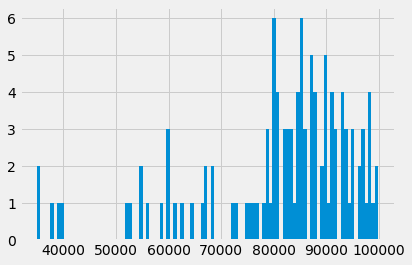

In [153]:
train[train['SalePrice'] < 100000]['SalePrice'].hist(bins=100)

In [154]:
train.drop_duplicates(inplace=True)

In [155]:
X_train = train.drop(columns={'SalePrice', 'Id'}, axis=1)
y_train = train['SalePrice']


num_features = X_train.select_dtypes(include=np.number).columns.tolist()
cat_features = X_train.select_dtypes(['category']).columns.tolist()


pipelines = []
params = []

num_cols = num_features
cat_cols = cat_features

cat_transformer_linear = OneHotEncoder(handle_unknown='ignore')
num_transformer_linear = Pipeline([ ('Imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler()) ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer_linear, num_cols),
        ("cat", cat_transformer_linear, cat_cols)
    ]
)

In [156]:
# imputer = SimpleImputer(strategy='median')
# X_train[num_features] = imputer.fit_transform(X_train[num_features])
# print(train['LotFrontage'].isna().sum())

# #top models table
#     print('Top ' + name + ' models:')
#     results_df = pd.DataFrame(gs.cv_results_)
#     results_df = results_df.sort_values(by=["rank_test_score"])
#     display(results_df[['params', 'mean_test_score', 'mean_fit_time', 'rank_test_score']]
#             .head(5)
#             .rename(columns={'mean_test_score': 'cv_score'})
#             .rename(columns={'rank_test_score': 'rank_cv_score'}))

#     #best cv score
#     print('best cv score of ' + name + ' model:')
#     print(gs.best_score_)

#     #test score of best estimator + time prediction calculation
#     print('Test ' + name + ' score:')
#     start = time.time()
#     print(mean_squared_error(y_test, gs.best_estimator_.predict(X_test), squared=False))
#     pred_time = time.time() - start

#     #time prediction speed of best estimator
#     print('Prediction time best ' + name + ' model:')
#     print(pred_time)   
#     print()
#     print()     


In [157]:
pipeline_tree = Pipeline([('preprocessor_linear', preprocessor), ('trun_svd', TruncatedSVD(n_components=5)),
                          ('tree', None)])

In [158]:
param_tree = [
    {'tree': (DecisionTreeRegressor(random_state=1),),
     'tree__max_depth': range(1, 20, 5),
     },

    # {'tree': (RandomForestRegressor(random_state=1),),
    #  'tree__n_estimators': range(1, 20, 5),
    #  'tree__max_depth': range(1, 20, 5),
    #  }
]

In [159]:
gs = GridSearchCV(pipeline_tree,
                  param_tree,
                  scoring='neg_root_mean_squared_error',
                  refit='neg_root_mean_squared_error',
                  n_jobs=10,
                  cv=5 )


               

In [160]:
gs.fit(X_train, y_train)  
gs.best_score_

-54251.47410597866